In [1]:
import rasterio as rio
import geopandas as gpd
import fiona

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import classification_report, accuracy_score

In [3]:
# variables 
# Note: labels should be always last column with name "labels"
# Note: Make sure input labels shapefile and input raster have same CRS, otherwise code will not run


raster_loc = 'data/rasters/s2_img.tif'
points_loc = 'data/sample_points/samples.shp'


temp_point_loc = 'data/temp/temp_y_points.shp'

lulc_name = ['Water', 'Dense Veg', 'Veg', 'Urban', 'Barren']

## sampling

In [5]:
%%time

#  reading bands from input
with rio.open(raster_loc) as img:
    bands = (img.read()).shape[0]
print('Bands of input image: ', bands)

# using ilteration to automatically create a bands list

features = []
for i in range(bands):
    features.append('band'+str(i+1))
print('Bands names: ', features)
f_len = len(features)

points = gpd.read_file(points_loc)
# adding a new column 'id' with range of points
points = points.assign(id=range(len(points)))
# saving nenw point file with 'id'
points.to_file(temp_point_loc) 
# converting gdf to pd df and removing geometry
points_df = pd.DataFrame(points.drop(columns='geometry'))

# ilterating over multiband raster
sampled = pd.Series()

#inputShape= temp_point_loc
# Read input shapefile with fiona and iterate over each feature
with fiona.open(temp_point_loc) as shp:
    for feature in shp:
        siteID = feature['properties']['id']
        coords = feature['geometry']['coordinates']
        # Read pixel value at the given coordinates using Rasterio
        # NB: `sample()` returns an iterable of ndarrays.
        with rio.open(raster_loc) as stack_src:
                  value = [v for v in stack_src.sample([coords])]
        # Update the pandas serie accordingly
        sampled.loc[siteID] = value

# reshaping sampled values
df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df1['id'] = df1.index
df1 = pd.DataFrame(df1[0].values.tolist(), 
                   columns=features)
df1['id'] = df1.index

data = pd.merge(df1, points_df, on ='id')
print('Sampled Data: \n',data)

x = data.iloc[:,0:f_len]
X = x.values
y = data.iloc[:,-1]
Y = y.values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, stratify = Y)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')


Bands of input image:  4
Bands names:  ['band1', 'band2', 'band3', 'band4']


<timed exec>:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Sampled Data: 
        band1    band2    band3    band4   id  labels
0    0.03090  0.04390  0.02270  0.00880    0       1
1    0.03360  0.04620  0.02230  0.01010    1       1
2    0.02945  0.04285  0.02275  0.01075    2       1
3    0.02960  0.04420  0.02260  0.00930    3       1
4    0.03060  0.04440  0.02170  0.00810    4       1
..       ...      ...      ...      ...  ...     ...
423  0.12040  0.16290  0.22670  0.34460  423       5
424  0.09385  0.12630  0.17890  0.28920  424       5
425  0.08210  0.11480  0.15890  0.29490  425       5
426  0.11070  0.14420  0.20410  0.33260  426       5
427  0.09250  0.12560  0.17350  0.32800  427       5

[428 rows x 6 columns]
X_train Shape: (299, 4)
X_test Shape: (129, 4)
y_train Shape: (299,)
y_test Shape:(129,)
CPU times: total: 8.56 s
Wall time: 12.9 s


# Support Vector Machine (SVM)

Accuracy SVM: 95.34883720930233
              precision    recall  f1-score   support

           1       0.95      1.00      0.97        18
           2       0.97      1.00      0.99        33
           3       0.90      0.83      0.86        23
           4       1.00      0.93      0.96        27
           5       0.93      1.00      0.97        28

    accuracy                           0.95       129
   macro avg       0.95      0.95      0.95       129
weighted avg       0.95      0.95      0.95       129

Confusion Matrix RF: 
 [[18  0  0  0  0]
 [ 0 33  0  0  0]
 [ 1  1 19  0  2]
 [ 0  0  2 25  0]
 [ 0  0  0  0 28]]


Text(48.74999999999999, 0.5, 'Actual')

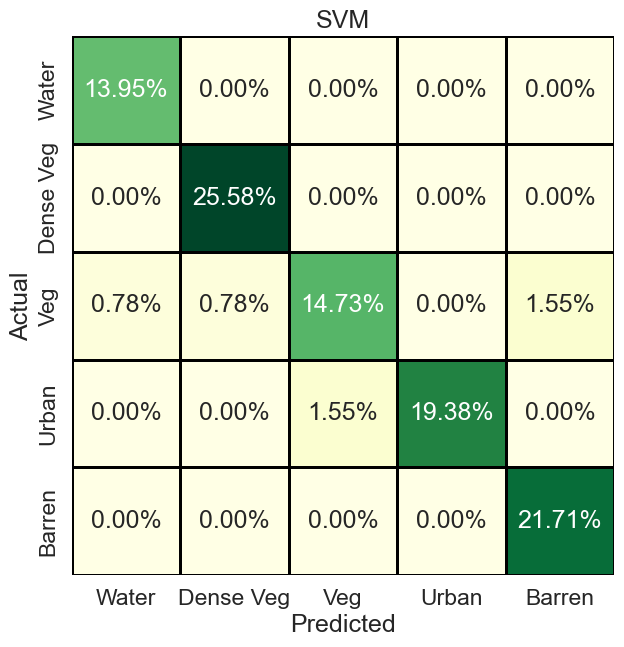

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
cName = 'SVM'
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))

# Confusion Matrix

cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

## full data reshaping, predicting, and saving output

In [7]:
%%time
cName = 'SVM'
exp_name = f'data/results/lulc_{cName}.tif'


img = rio.open(raster_loc)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')
# Predefining out raster meta using variable raster
tempfile_arr = img.read(1)
tempfile_arr = tempfile_arr.reshape(-1,1)
metadata = img.meta

height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 4523
Width: 5183
Bands: 4

reshaped full data shape  for prediction:  (23442709, 4)
Prediction Done, now exporting raster 

Map saved SVM.................
CPU times: total: 1min 55s
Wall time: 4min 13s


## Random Forest

Accuracy RF: 96.12403100775194
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        33
           3       0.91      0.87      0.89        23
           4       0.96      0.93      0.94        27
           5       0.93      1.00      0.97        28

    accuracy                           0.96       129
   macro avg       0.96      0.96      0.96       129
weighted avg       0.96      0.96      0.96       129

Confusion Matrix RF: 
 [[18  0  0  0  0]
 [ 0 33  0  0  0]
 [ 0  0 20  1  2]
 [ 0  0  2 25  0]
 [ 0  0  0  0 28]]
CPU times: total: 266 ms
Wall time: 1.22 s


Text(48.74999999999999, 0.5, 'Actual')

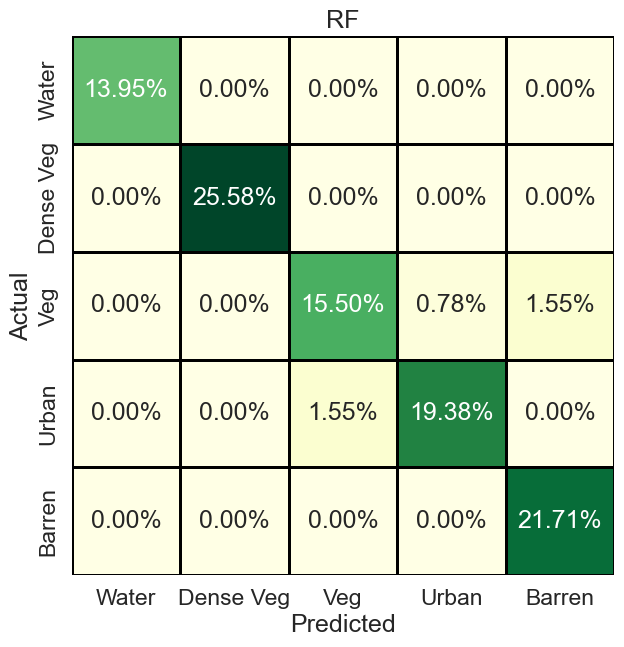

In [8]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

cName = 'RF'


clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

## full data reshaping, predicting, and saving output

In [9]:
%%time

cName = 'RF'
exp_name = f'data/results/lulc_{cName}.tif'


img = rio.open(raster_loc)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')
# Predefining out raster meta using variable raster
tempfile_arr = img.read(1)
tempfile_arr = tempfile_arr.reshape(-1,1)
metadata = img.meta

height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 4523
Width: 5183
Bands: 4

reshaped full data shape  for prediction:  (23442709, 4)
Prediction Done, now exporting raster 

Map saved RF.................
CPU times: total: 1min 31s
Wall time: 2min 41s


## Decision Tree

Accuracy DT: 97.67441860465115
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        33
           3       1.00      0.87      0.93        23
           4       0.96      1.00      0.98        27
           5       0.93      1.00      0.97        28

    accuracy                           0.98       129
   macro avg       0.98      0.97      0.98       129
weighted avg       0.98      0.98      0.98       129

Confusion Matrix RF: 
 [[18  0  0  0  0]
 [ 0 33  0  0  0]
 [ 0  0 20  1  2]
 [ 0  0  0 27  0]
 [ 0  0  0  0 28]]
CPU times: total: 78.1 ms
Wall time: 118 ms


Text(48.74999999999999, 0.5, 'Actual')

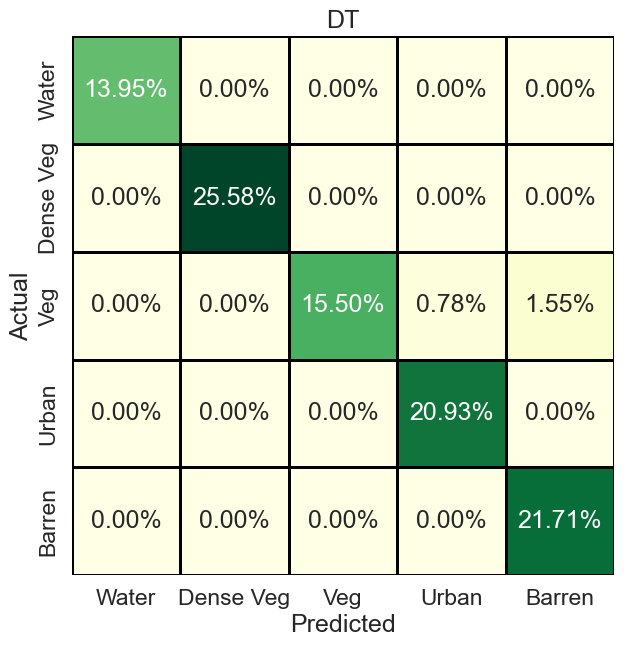

In [10]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

cName = 'DT'

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

In [11]:
%%time

cName = 'DT'
exp_name = f'data/results/lulc_{cName}.tif'


img = rio.open(raster_loc)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')
# Predefining out raster meta using variable raster
tempfile_arr = img.read(1)
tempfile_arr = tempfile_arr.reshape(-1,1)
metadata = img.meta

height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 4523
Width: 5183
Bands: 4

reshaped full data shape  for prediction:  (23442709, 4)
Prediction Done, now exporting raster 

Map saved DT.................
CPU times: total: 3.22 s
Wall time: 4.85 s
